In [2]:
import windio2cad.geometry_tools

In [31]:
from typing import Dict, List, Any, Optional
import argparse
import yaml
import numpy as np
from scipy.interpolate import Rbf as spline
import windio2cad.geometry_tools as geom
import solid
import subprocess
from numpy.linalg import norm
from math import sin, cos
import matplotlib.pyplot as plt


class Blade:
    """
    This class renders one blade for the rotor.
    """

    def __init__(self, yaml_filename: str):
        """
        The constructor opens the YAML file and extracts the blade
        and airfoil information into instance attributes.

        Parameters
        ----------
        yaml_filename: str
            Filename that contains the geometry for the rotor.
        """
        geometry = yaml.load(open(yaml_filename, "r"), yaml.FullLoader)
        self.outer_shape = geometry["components"]["blade"]["outer_shape_bem"]
        self.airfoils = geometry["airfoils"]

    @staticmethod
    def myinterp(xi, x, f) -> np.array:
        # print(x, f)
        print(len(x), len(f))
        myspline = spline(x, f)
        return myspline(xi)

    def generate_lofted(self, n_span_min=10, n_xy=8) -> np.array:
        """
        Creates the lofted shape of a blade and returns a NumPy array
        of the polygons at each cross section.

        Parameters
        ----------
        n_span_min: int
            Number of cross sections to create across span of
            blade.

        n_xy: int
            The number of x, y points in the polygons at each slice of
            the blade.

        Returns
        -------
        np.array
            An array of the polygons at each cross section of the blade.
        """
        # Use yaml grid points and others that we add
        r_span = np.unique(
            np.r_[
                np.linspace(0.0, 1.0, n_span_min),
                self.outer_shape["chord"]["grid"],
                self.outer_shape["twist"]["grid"],
                self.outer_shape["pitch_axis"]["grid"],
                self.outer_shape["reference_axis"]["x"]["grid"],
                self.outer_shape["reference_axis"]["y"]["grid"],
                self.outer_shape["reference_axis"]["z"]["grid"],
            ]
        )
        n_span = len(r_span)

        # print(r_span)
        

        # Read in blade spanwise geometry values and put on common grid
        chord = self.myinterp(
            r_span,
            self.outer_shape["chord"]["grid"],
            self.outer_shape["chord"]["values"],
        )
        twist = self.myinterp(
            r_span,
            self.outer_shape["twist"]["grid"],
            self.outer_shape["twist"]["values"],
        )
        pitch_axis = self.myinterp(
            r_span,
            self.outer_shape["pitch_axis"]["grid"],
            self.outer_shape["pitch_axis"]["values"],
        )
        ref_axis = np.c_[
            self.myinterp(
                r_span,
                self.outer_shape["reference_axis"]["x"]["grid"],
                self.outer_shape["reference_axis"]["x"]["values"],
            ),
            self.myinterp(
                r_span,
                self.outer_shape["reference_axis"]["y"]["grid"],
                self.outer_shape["reference_axis"]["y"]["values"],
            ),
            self.myinterp(
                r_span,
                self.outer_shape["reference_axis"]["z"]["grid"],
                self.outer_shape["reference_axis"]["z"]["values"],
            ),
        ]

        # Get airfoil names and thicknesses
        af_position = self.outer_shape["airfoil_position"]["grid"]
        af_used = self.outer_shape["airfoil_position"]["labels"]
        n_af_span = len(af_position)
        n_af = len(self.airfoils)
        name = n_af * [""]
        r_thick = np.zeros(n_af)
        for i in range(n_af):
            name[i] = self.airfoils[i]["name"]
            r_thick[i] = self.airfoils[i]["relative_thickness"]

        fig, ax1 = plt.subplots()

        # Create common airfoil coordinates grid
        coord_xy = np.zeros((n_af, n_xy, 2))
        for i in range(n_af):
            points = np.c_[
                self.airfoils[i]["coordinates"]["x"],
                self.airfoils[i]["coordinates"]["y"],
            ]

            # Check that airfoil points are declared from the TE suction side to TE pressure side
            idx_le = np.argmin(points[:, 0])
            if np.mean(points[:idx_le, 1]) > 0.0:
                points = np.flip(points, axis=0)
            if i == 2:
                ax1.plot(points[:,0], points[:, 1])
                ax1.set_xlabel('x')
                ax1.set_ylabel('y')
            
            # Remap points using class AirfoilShape
            af = geom.AirfoilShape(points=points)
            af.redistribute(n_xy, even=False, dLE=True)
            af_points = af.points

            # Add trailing edge point if not defined
            if [1, 0] not in af_points.tolist():
                af_points[:, 0] -= af_points[np.argmin(af_points[:, 0]), 0]
            c = max(af_points[:, 0]) - min(af_points[:, 0])
            af_points[:, :] /= c

            coord_xy[i, :, :] = af_points

            if i == 2:
                ax1.plot(coord_xy[i,:,0], coord_xy[i, :,1])
                ax1.set_xlabel('x')
                ax1.set_ylabel('y')

            # if 25 > ref_axis[i, 2] > 24:
            #     ax1.plot(coord_xy[i,:,0], coord_xy[i, :,1])
            #     ax1.set_xlabel('x')
            #     ax1.set_ylabel('y')

        # Reconstruct the blade relative thickness along span with a pchip
        r_thick_used = np.zeros(n_af_span)
        coord_xy_used = np.zeros((n_af_span, n_xy, 2))
        coord_xy_interp = np.zeros((n_span, n_xy, 2))
        coord_xy_dim = np.zeros((n_span, n_xy, 2))

        for i in range(n_af_span):
            for j in range(n_af):
                if af_used[i] == name[j]:
                    r_thick_used[i] = r_thick[j] * 3
                    coord_xy_used[i, :, :] = coord_xy[j, :, :]
            
            if i == 2:
                ax1.plot(coord_xy_used[i,:,0], coord_xy_used[i, :,1])
                ax1.set_xlabel('x')
                ax1.set_ylabel('y')

        r_thick_interp = self.myinterp(r_span, af_position, r_thick_used)

        # Spanwise interpolation of the profile coordinates with a pchip
        r_thick_unique, indices = np.unique(r_thick_used, return_index=True)

        print(r_thick_interp.shape, r_thick_unique.shape, coord_xy_used[indices, :, :].shape)
        coord_xy_interp = np.flip(
            self.myinterp(
                np.flip(r_thick_interp), r_thick_unique, coord_xy_used[indices, :, :]
            ),
            axis=0,
        )
        for i in range(n_span):
            if 25 > ref_axis[i, 2] > 24:
                ax1.plot(coord_xy_interp[i,:,0], coord_xy_interp[i, :,1])
                ax1.set_xlabel('x')
                ax1.set_ylabel('y')
            # Correction to move the leading edge (min x point) to (0,0)
            af_le = coord_xy_interp[i, np.argmin(coord_xy_interp[i, :, 0]), :]
            coord_xy_interp[i, :, 0] -= af_le[0]
            coord_xy_interp[i, :, 1] -= af_le[1]
            c = max(coord_xy_interp[i, :, 0]) - min(coord_xy_interp[i, :, 0])
            coord_xy_interp[i, :, :] /= c
            # If the rel thickness is smaller than 0.4 apply a trailing ege smoothing step
            # if r_thick_interp[i] < 0.4:
                # coord_xy_interp[i, :, :] = geom.trailing_edge_smoothing(
                    # coord_xy_interp[i, :, :]
                # )
            
            # ax1.plot(coord_xy_interp[i,:,0], coord_xy_interp[i, :,1])
            # ax1.set_xlabel('x')
            # ax1.set_ylabel('y')

        # Offset by pitch axis and scale for chord
        coord_xy_dim = coord_xy_interp.copy()
        coord_xy_dim[:, :, 0] -= pitch_axis[:, np.newaxis]
        coord_xy_dim = coord_xy_dim * chord[:, np.newaxis, np.newaxis]

        # Rotate to twist angle
        coord_xy_dim_twisted = np.zeros(coord_xy_interp.shape)
        for i in range(n_span):
            # ax1.plot(coord_xy_dim[i,:,0], coord_xy_dim[i, :,1])
            # ax1.set_xlabel('x')
            # ax1.set_ylabel('y')
            x = coord_xy_dim[i, :, 0]
            y = coord_xy_dim[i, :, 1]
            coord_xy_dim_twisted[i, :, 0] = x * np.cos(twist[i]) - y * np.sin(twist[i])
            coord_xy_dim_twisted[i, :, 1] = y * np.cos(twist[i]) + x * np.sin(twist[i])

            # ax1.plot(coord_xy_dim_twisted[i,:,0], coord_xy_dim_twisted[i, :,1])
            # ax1.set_xlabel('x')
            # ax1.set_ylabel('y')

        # Assemble lofted shape along reference axis
        lofted_shape = np.zeros((n_span, n_xy, 3))
        for i in range(n_span):
            for j in range(n_xy):
                lofted_shape[i, j, :] = (
                    np.r_[
                        coord_xy_dim_twisted[i, j, 1],
                        coord_xy_dim_twisted[i, j, 0],
                        0.0,
                    ]
                    + ref_axis[i, :]
                )
            # if 25 > ref_axis[i, 2] > 24:
            #     ax1.plot(lofted_shape[i,:,0], lofted_shape[i, :,1])
            #     ax1.set_xlabel('x')
            #     ax1.set_ylabel('y')

        return lofted_shape

    def blade_hull(self, downsample_z: int = 1) -> solid.OpenSCADObject:
        """
        This creates an OpenSCAD hull object around cross sections of a blade,
        thereby rendering the complete geometry for a single blade.

        Parameters
        ----------
        downsample_z: int
            Skips to every nth sample across the z axis of the blade. For
            example, 10 uses only every tenth cross section.

        Returns
        -------
        solid.OpenSCADObject
            The OpenSCAD object that is ready to render to code.
        """

        # Get the lofted shape and the number of sections across its span
        lofted_shape = self.generate_lofted()
        n_span = lofted_shape.shape[0]

        # Find the distance between each cross section. Find the minimum of
        # these distances and multiply by 0.1. This will be the height of each
        # extrusion for each cross section.

        diff_z = []
        for k in range(n_span - 1):
            diff_z.append(lofted_shape[k + 1, 0, 2] - lofted_shape[k, 0, 2])
        dz = 0.1 * min(diff_z)

        # Make the range to sample the span of the blade. If downsample_z
        # is 1, that means every cross section will be plotted. If it is
        # greater than 1, samples will be skipped. This is reflected in
        # the range to sample the span.

        if downsample_z == 1:
            n_span_range = range(n_span)
        else:
            n_span_range = range(0, n_span, downsample_z)

        # Create one extrusion per cross section.
        extrusions = []
        for k in n_span_range:
            bottom = lofted_shape[k, 0, 2]
            points = tuple((row[0], row[1]) for row in lofted_shape[k, :, :])
            polygon = solid.polygon(points)
            extrusion = solid.linear_extrude(dz)(polygon)
            translated_extrusion = solid.translate((0.0, 0.0, bottom))(extrusion)
            extrusions.append(translated_extrusion)

        # Create a hull around all the cross sections and return it.
        hull_of_extrusions = solid.hull()(extrusions)
        return hull_of_extrusions

10
60 60
50 50
50 50
50 50
50 50
50 50
10 10
(358,) (8,) (8, 300, 2)
8 8


ValueError: All arrays must be equal length.

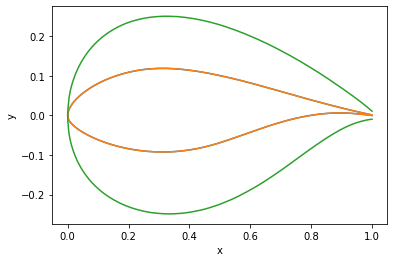

In [32]:
blade = Blade('IEA-15-240-RWT.yaml')
print(len(blade.outer_shape['airfoil_position']['labels']))
points = blade.generate_lofted(n_span_min=300, n_xy=300)
# points = blade.blade_hull(downsample_z = 10)

print(points.shape)


# f = open('surf_coarse.plt','w')

# f.write('TITLE = \" WINDIO TEST CASE\" \n')
# f.write('VARIABLES = \"X\" \"Y\" \"Z\" \n')
# f.write('ZONE I= {} J = {} F=point \n'.format(points.shape[1] + 1, int(points.shape[0]/6)))
# for i in range(points.shape[0]):
#     if i % 6 == 0 :
#         for j in range(points.shape[1]):
#             f.write('{} \t {} \t {}\n'.format(points[i, j, 0], points[i, j, 1], points[i, j, 2]))
#         f.write('{} \t {} \t {}\n'.format(points[i, 0, 0], points[i, 0, 1], points[i, 0, 2]))

# f.close()


f = open('surf_coarse.plt','w')

f.write('TITLE = \" WINDIO TEST CASE\" \n')
f.write('VARIABLES = \"X\" \"Y\" \"Z\" \n')
f.write('ZONE I= {} J = {} F=point \n'.format(points.shape[1] + 1, (points.shape[0])))
for i in range(points.shape[0]):
    for j in range(points.shape[1]):
        f.write('{} \t {} \t {}\n'.format(points[i, j, 0], points[i, j, 1], points[i, j, 2]))
    f.write('{} \t {} \t {}\n'.format(points[i, 0, 0], points[i, 0, 1], points[i, 0, 2]))

f.close()


f = open('../FLOWSOLVER2018/IEA_15MW/tiny/IEA_15MW_patch.dat','w')
f.write('{} \t {} \n'.format(points.shape[1] + 1, points.shape[0]))
for i in range(points.shape[0]):
    for j in range(points.shape[1]):
        f.write('{} \t {} \t {}\n'.format(points[i, j, 1], points[i, j, 2] + 3, points[i, j, 0]))
    f.write('{} \t {} \t {}\n'.format(points[i, 0, 1], points[i, 0, 2] + 3, points[i, 0, 0]))

f.close()

f = open('surf_coarse.p3d','w')

npts = points.shape[0] * points.shape[1]

f.write('{} \t {} \t {} \n'.format(points.shape[1] + 1, points.shape[0], 1))
for i in range(points.shape[0]):
    for j in range(points.shape[1]):
        f.write('{}\n'.format(points[i, j, 0]))
    f.write('{}\n'.format(points[i, 0, 0]))
for i in range(points.shape[0]):
    for j in range(points.shape[1]):
        f.write('{}\n'.format(points[i, j, 1]))
    f.write('{}\n'.format(points[i, 0, 1]))
for i in range(points.shape[0]):
    for j in range(points.shape[1]):
        f.write('{}\n'.format(points[i, j, 2]))
    f.write('{}\n'.format(points[i, 0, 2]))



f.close()

print(points.shape)



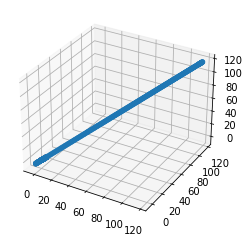

In [7]:
import matplotlib.pyplot as plt 

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(points[:,0], points[:,1], points[:,2])



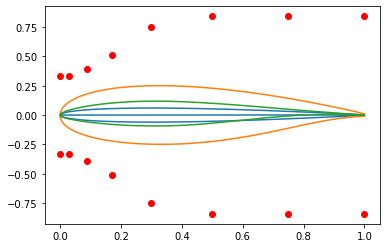

In [8]:
import matplotlib.pyplot as plt
import numpy as np

SNL = np.loadtxt('foils/SNL-FFA-W3-500.dat', skiprows=3)
FFA221 = np.loadtxt('foils/FFA-W3-211.dat', skiprows=3)
naca0012 = np.loadtxt('data/n0012.dat', skiprows=3)


circ_x = [1.00000, 0.99901, 0.99606, 0.99114, 0.98429, 0.97553, 0.96489, 0.95241, 0.93815, 0.92216, 0.90451, 0.88526, 0.86448, 0.84227, 0.81871, 0.79389, 0.76791, 0.74088, 0.71289, 0.68406, 0.65451, 0.62434, 0.59369, 0.56267, 0.53140, 0.50000, 0.46860, 0.43733, 0.40631, 0.37566, 0.34549, 0.31594, 0.28711, 0.25912, 0.23209, 0.20611, 0.18129, 0.15773, 0.13552, 0.11474, 0.09549, 0.07784, 0.06185, 0.04759, 0.03511, 0.02447, 0.01571, 0.00886, 0.00394, 0.00099, 0.00000, 0.00099, 0.00394, 0.00886, 0.01571, 0.02447, 0.03511, 0.04759, 0.06185, 0.07784, 0.09549, 0.11474, 0.13552, 0.15773, 0.18129, 0.20611, 0.23209, 0.25912, 0.28711, 0.31594, 0.34549, 0.37566, 0.40631, 0.43733, 0.46860, 0.50000, 0.53140, 0.56267, 0.59369, 0.62434, 0.65451, 0.68406, 0.71289, 0.74088, 0.76791, 0.79389, 0.81871, 0.84227, 0.86448, 0.88526, 0.90451, 0.92216, 0.93815, 0.95241, 0.96489, 0.97553, 0.98429, 0.99114, 0.99606, 0.99901, 1.00000]
circ_y = [0.00000, 0.03140, 0.06267, 0.09369, 0.12434, 0.15451, 0.18406, 0.21289, 0.24088, 0.26791, 0.29389, 0.31871, 0.34227, 0.36448, 0.38526, 0.40451, 0.42216, 0.43815, 0.45241, 0.46489, 0.47553, 0.48429, 0.49114, 0.49606, 0.49901, 0.50000, 0.49901, 0.49606, 0.49114, 0.48429, 0.47553, 0.46489, 0.45241, 0.43815, 0.42216, 0.40451, 0.38526, 0.36448, 0.34227, 0.31871, 0.29389, 0.26791, 0.24088, 0.21289, 0.18406, 0.15451, 0.12434, 0.09369, 0.06267, 0.03140, 0.00000, -0.03140, -0.06267, -0.09369, -0.12434, -0.15451, -0.18406, -0.21289, -0.24088, -0.26791, -0.29389, -0.31871, -0.34227, -0.36448, -0.38526, -0.40451, -0.42216, -0.43815, -0.45241, -0.46489, -0.47553, -0.48429, -0.49114, -0.49606, -0.49901, -0.50000, -0.49901, -0.49606, -0.49114, -0.48429, -0.47553, -0.46489, -0.45241, -0.43815, -0.42216, -0.40451, -0.38526, -0.36448, -0.34227, -0.31871, -0.29389, -0.26791, -0.24088, -0.21289, -0.18406, -0.15451, -0.12434, -0.09369, -0.06267, -0.03140, 0.00000]

fig, ax1 = plt.subplots()
ax1.plot(naca0012[:, 0], naca0012[:,1])
# ax1.plot(circ_x, circ_y)

# control_cage_x = np.array([0.8, 0.5, 0.3, 0.1, 0, -0.1, 0, 0.1, 0.3, 0.5, 0.8])
# control_cage_y = np.array([1, 1, 1, 1, 0.5, 0, -0.5, -1, -1, -1, -1])

section = np.loadtxt('data/domain.ctr.asa.16', skiprows=1)
x = section[:, 0]
y = section[:, 2] * 3

# control_cage_y = control_cage_y * 10

ax1.plot(x, y, 'ro')
ax1.plot(SNL[:, 0], SNL[:, 1])
ax1.plot(FFA221[:, 0], FFA221[:, 1])


circular
circular
SNL-FFA-W3-500
FFA-W3-360
FFA-W3-330blend
FFA-W3-301
FFA-W3-270blend
FFA-W3-241
FFA-W3-211
FFA-W3-211
[[[ 1.07290569e-01  3.61451811e+00  1.75500000e+01]
  [-1.63016819e-01  2.22808668e+00  1.75500000e+01]
  [-4.33324206e-01  8.41655257e-01  1.75500000e+01]
  [-5.66384231e-01 -2.83708326e-01  1.75500000e+01]
  [-4.85115044e-01 -1.04790185e+00  1.75500000e+01]
  [-4.60698894e-01 -1.51318450e+00  1.75500000e+01]
  [-4.70115410e-01 -1.85674033e+00  1.75500000e+01]
  [-5.02552297e-01 -2.02311210e+00  1.75500000e+01]
  [ 1.07477530e-01 -2.14204735e+00  1.75500000e+01]
  [ 1.39914416e-01 -1.97567558e+00  1.75500000e+01]
  [ 2.60245446e-01 -1.65374434e+00  1.75500000e+01]
  [ 4.57658324e-01 -1.23171087e+00  1.75500000e+01]
  [ 8.20047194e-01 -5.54015713e-01  1.75500000e+01]
  [ 1.11947899e+00  5.38910983e-01  1.75500000e+01]
  [ 1.38978638e+00  1.92534241e+00  1.75500000e+01]
  [ 1.66009376e+00  3.31177383e+00  1.75500000e+01]]

 [[ 1.58269523e-01  3.89850587e+00  2.79500000

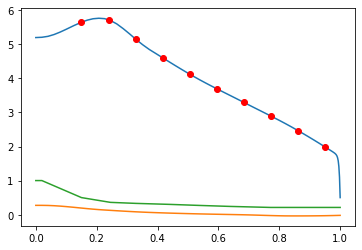

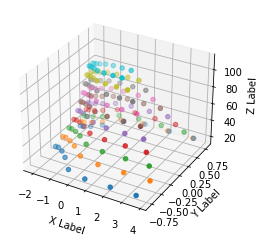

In [9]:
blade = Blade('IEA-15-240-RWT.yaml')

# Get surface distribution data

chord_d = blade.outer_shape['chord']
twist_d = blade.outer_shape['twist']
pitch_axis_d = blade.outer_shape['pitch_axis']
x_d = blade.outer_shape['reference_axis']['x']
y_d = blade.outer_shape['reference_axis']['y']
z_d = blade.outer_shape['reference_axis']['z']

thick_d = {'grid' : [], 'values' : []}


for section in blade.outer_shape['airfoil_position']['labels']:
    print(section)
    thick_d['values'].append(next(item for item in blade.airfoils if item["name"] == section)['relative_thickness'])

for grid in blade.outer_shape['airfoil_position']['grid']:
    thick_d['grid'].append(grid)

plt.plot(chord_d['grid'], chord_d['values'])
plt.plot(twist_d['grid'], twist_d['values'])
plt.plot(thick_d['grid'], thick_d['values'])

# interpolate datasets
n_stations = 10

locations = np.linspace(0.15, 0.95, n_stations)


chord_i = np.interp(locations, chord_d['grid'], chord_d['values'])
twist_i = np.interp(locations, twist_d['grid'], twist_d['values'])
thick_i = np.interp(locations, thick_d['grid'], thick_d['values'])
pitch_axis_i = np.interp(locations, pitch_axis_d['grid'], pitch_axis_d['values'])
x_i = np.interp(locations, x_d['grid'], x_d['values'])
y_i = np.interp(locations, y_d['grid'], y_d['values'])
z_i = np.interp(locations, z_d['grid'], z_d['values'])

plt.plot(locations, chord_i, 'ro')

# Prepare control cage

section = np.loadtxt('data/domain_ordered.ctr.asa.16', skiprows=1)
x = section[:, 0]
y = section[:, 2]

control_cage_x = x
control_cage_y = y

fig = plt.figure()
ax = fig.add_subplot(projection='3d')


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

f = open('data/control_cage.plt','w')

f.write('TITLE = \" WINDIO TEST CASE\" \n')
f.write('VARIABLES = \"X\" \"Y\" \"Z\" \n')
f.write('ZONE I= {} J = {} F=point \n'.format(len(control_cage_x), n_stations))

cage = np.zeros((n_stations, len(x), 3))


for i in range(n_stations):
    local_cage_x = (control_cage_x[:] - pitch_axis_i[i]) * chord_i[i] 
    local_cage_y = control_cage_y[:] * chord_i[i] * thick_i[i]
    local_cage_z = np.ones_like(local_cage_x) * z_i[i]

    local_cage_x_twist = local_cage_x * np.cos(twist_i[i]) - local_cage_y * np.sin(twist_i[i])
    local_cage_y_twist = local_cage_y * np.cos(twist_i[i]) + local_cage_x * np.sin(twist_i[i])

    # rotate 90 around reference axis
    global_cage_x = x[i] + (local_cage_x_twist - x_i[i]) * np.cos(np.pi/2) - (local_cage_y_twist - y[i]) * np.sin(np.pi/2)
    global_cage_y = y[i] + (local_cage_x_twist - x_i[i]) * np.sin(np.pi/2) + (local_cage_y_twist - y[i]) * np.cos(np.pi/2)


    ax.scatter(local_cage_x, local_cage_y, local_cage_z)
    for j in range(len(local_cage_x)):
        f.write('{} \t {} \t {}\n'.format(local_cage_y_twist[j] + x_i[i], local_cage_x_twist[j] + y_i[i], local_cage_z[j]))
        # f.write('{} \t {} \t {}\n'.format(global_cage_x[j], global_cage_y[j], local_cage_z[j]))
        cage[i, j, :] = np.c_[local_cage_y_twist[j] + x_i[i], local_cage_x_twist[j] + y_i[i], local_cage_z[j]]

f.close()

print(cage)

In [10]:
f = open('control_cage.plt','w')

f.write('TITLE = \" WINDIO TEST CASE\" \n')
f.write('VARIABLES = \"X\" \"Y\" \"Z\" \n')
f.write('ZONE I= {} J = {} F=point \n'.format(points.shape[1] + 1, int(points.shape[0]/6)))
for i in range(points.shape[0]):
    if i % 6 == 0 :
        for j in range(points.shape[1]):
            f.write('{} \t {} \t {}\n'.format(points[i, j, 0], points[i, j, 1], points[i, j, 2]))
        f.write('{} \t {} \t {}\n'.format(points[i, 0, 0], points[i, 0, 1], points[i, 0, 2]))

f.close()


circular
circular
SNL-FFA-W3-500
FFA-W3-360
FFA-W3-330blend
FFA-W3-301
FFA-W3-270blend
FFA-W3-241
FFA-W3-211
FFA-W3-211


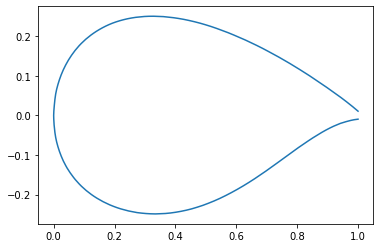

In [11]:
for section in blade.outer_shape['airfoil_position']['labels']:
    print(section)

    x = next(item for item in blade.airfoils if item["name"] == section)['coordinates']['x']
    z = next(item for item in blade.airfoils if item["name"] == section)['coordinates']['y']

    f = open('foils/{}.dat'.format(section),'w')

    f.write('VARIABLES = \"x\", \"z\" \n')
    f.write('ZONE T="Aerofoil", I= {}, F=point \n'.format(len(x)))
    for i in range(len(x)):
        f.write('{} \t {}\n'.format(x[i], z[i]))
    
    if section == 'SNL-FFA-W3-500':
        plt.plot(x, z)

    f.close()